# Partisan symmetry

In this notebook, we're going to use data from U.S. House of Representatives elections to understand how votes translate to seats. In particular, we're going to look at the concept of partisan symmetry. Roughly, partisan symmetry is the idea that if Party A gets 58% of the seats with 51% of the votes, then if voter preferences change so that Party B gets 51% of the votes, Party B should also get 58% of the seats.


In [13]:
# First, let's get that data (taken from https://electionlab.mit.edu/data)

import pandas as pd
import numpy as np

historical_elections = pd.read_csv('data/1976-2018-house.csv', encoding = "ISO-8859-1")  # Load MIT Election Lab Data
# print(historical_elections.columns.values)  # Print column names
    
want_statewide_vote_share = True

if want_statewide_vote_share:
    x_label = "Statewide Republican vote share"
else:
    x_label = "Average district Republican vote share"

In [14]:
# We want to get the number of votes for Republicans and Democrats in each election.

def get_two_party_votes(state, year):
    in_state = historical_elections['state_po'] == state
    in_year = historical_elections["year"] == year

    results_in_state_and_year = historical_elections[in_state & in_year]
    
    in_republican_party = results_in_state_and_year['party'] == "republican"
    in_democratic_party = (results_in_state_and_year['party'] == "democrat") | (results_in_state_and_year['party'] == "democratic-farmer-labor")
    not_a_write_in = results_in_state_and_year['writein'] == False
    
    number_of_districts = np.amax(results_in_state_and_year['district'])
    
    district_offset = 1
    if number_of_districts == 0:
        number_of_districts = 1
        district_offset = 0

    republican_votes_by_district = []
    democrat_votes_by_district = []

    for i in range(number_of_districts):
        in_district = results_in_state_and_year['district'] == i + district_offset

        republican_in_district = results_in_state_and_year[in_district & in_republican_party & not_a_write_in]
        republican_candidates = republican_in_district['candidate'].values

        if len(republican_candidates) == 0:
            print('Warning! No Republican candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            republican_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == republican_in_district['candidate'].values[0]
            republican_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = republican_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            republican_vote = np.sum(np.array(all_votes_for_candidate))
            republican_votes_by_district.append(republican_vote)

        democrat_in_district = results_in_state_and_year[in_district & in_democratic_party]
        democrat_candidates = democrat_in_district['candidate'].values

        if len(democrat_candidates) == 0:
            print('Warning! No Democrat candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            democrat_votes_by_district.append(0)
        else:
            # The next are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == democrat_in_district['candidate'].values[0]
            democrat_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = democrat_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            democrat_vote = np.sum(np.array(all_votes_for_candidate))
            democrat_votes_by_district.append(democrat_vote)


        if republican_votes_by_district[-1] == 0 and democrat_votes_by_district[-1] == 0:
            print('Warning! No votes registered in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))

    return republican_votes_by_district, democrat_votes_by_district

    
# Get the fraction of votes each party got in each district, when the race is reduced to just two parties. 
def votes_to_shares_by_district(party_a_votes, party_b_votes):
    
    party_a_vote_share = []
    party_b_vote_share = []
    
    for i in range(len(party_a_votes)):
        total_votes = party_a_votes[i] + party_b_votes[i]
        if total_votes != 0:
            party_a_vote_share.append(party_a_votes[i]/(total_votes))
            party_b_vote_share.append(party_b_votes[i]/(total_votes))
        else:
            print('Warning! No votes registered in a district. District was omitted.')

    return party_a_vote_share, party_b_vote_share


# Get the vote and seat shares for party A
def district_vote_shares_to_vote_and_seat_shares(vote_shares_by_district):
    
    # Note! This is the average district vote share, not the overall vote share in the state
    # They would agree if turnout was equal across all districts.
    average_district_vote_share = np.mean(vote_shares_by_district)  
    seats_won = 0
    seat_total = 0
    
    for vote_share_in_district in vote_shares_by_district:
        seat_total = seat_total + 1
        if vote_share_in_district > 0.5:
            seats_won = seats_won + 1
    
    seat_share = seats_won/seat_total
    return average_district_vote_share, seat_share

# Get overall statewide vote share for each party
def votes_to_overall_vote_share(party_a_votes, party_b_votes):
    party_a_total = np.sum(party_a_votes)
    party_b_total = np.sum(party_b_votes)
    
    party_a_statewide_vote_share = party_a_total/(party_a_total + party_b_total)
    party_b_statewide_vote_share = party_b_total/(party_a_total + party_b_total)
    return party_a_statewide_vote_share, party_b_statewide_vote_share

## Seats-votes plane

Let's use the helper functions we defined in the cell above to plot elections in the *seats-votes plane*. This is the plane where vote shares are on the x-axis, and seat shares are on the y-axis. For all figures in this notebook, the vote shares being plotted are the _average district vote shares_. 

In MN 2016 U.S. House Races, Republicans won 37.5% of the seats.
The average district vote share was 47.76% Republican.
The statewide vote share was 48.2% Republican.


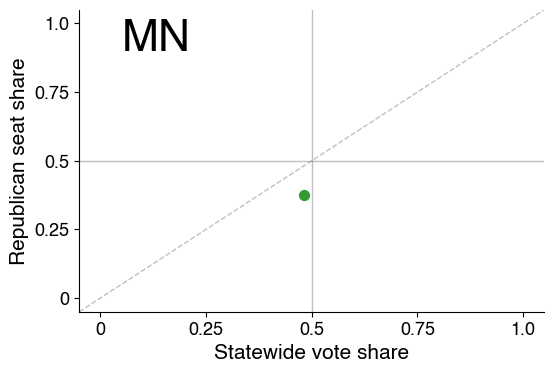

In [15]:
%run utilities

state = "MN"  # Choose your adventure
year = 2016

rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, year)
rep_vote_shares_by_district, dem_vote_shares_by_district = votes_to_shares_by_district(rep_votes_by_district, dem_votes_by_district)

average_district_republican_vote_share, rep_seat_share = district_vote_shares_to_vote_and_seat_shares(rep_vote_shares_by_district)
statewide_republican_vote_share, *_ = votes_to_overall_vote_share(rep_votes_by_district, dem_votes_by_district)

print("In " + state + " " + str(year) + " U.S. House Races, Republicans won " + str(round(rep_seat_share*100,2)) + '% of the seats.')
print("The average district vote share was " + str(round(average_district_republican_vote_share*100,2)) + '% Republican.')
print("The statewide vote share was " + str(round(statewide_republican_vote_share*100,2)) + '% Republican.')

if want_statewide_vote_share:
    plot_vote_and_seat_shares(statewide_republican_vote_share, rep_seat_share,state,x_label="Statewide vote share")
else:
    plot_vote_and_seat_shares(average_district_republican_vote_share, rep_seat_share,state)



Of course, the plots above condense the district vote shares to a single point (their average). To see how close each of the district races were, we can look at how close the margin of victory was for each district, in votes and percentage points:

In [16]:
make_competitiveness_table_for_state(rep_votes_by_district, dem_votes_by_district)

       District    Total votes   % Republican         Winner    Margin in %       in votes
              1        335,595           49.6              D            0.8          2,547
              2        341,285           51.0              R            1.9          6,655
              3        392,313           56.9              R           13.7         53,837
              4        324,332           37.3              D           25.4         82,266
              5        330,617           24.4              D           51.2        169,297
              6        358,395           65.7              R           31.4        112,375
              7        330,516           47.5              D            5.0         16,628
              8        356,185           49.7              D            0.6          2,009


# Uniform partisan swing

As mentioned above, partisan symmetry is the idea that if vote shares change, the seat shares should change in a way that is symmetric for the two parties.

But how can we predict how seat shares would change if voter preferences changed? We can make the uniform partisan swing assumption, and assume that voter preferences will change by the same amount, everywhere (uniformly).

To get at how many seats would Republicans win if every district swung their preference for Republicans by the same amount, imagine nudging the election results in each district by the same amount everywhere, and calculating for each nudge how many seats they would win. 

If we do this enough times, we can get a prediction for the seats won at every possible vote share between 0 and 1. 

In [17]:
# Here's an implementation of linear uniform partisan swing, based in average district vote share.

def ups_linear(vote_share_by_district):
    num_divisions = 1000
    vote_swings = np.arange(-1,1,1/num_divisions)

    votes = []
    seats = []
    mean_vote_share = np.mean(vote_share_by_district)
    
    for i in range(len(vote_swings)):
        
        delta_v = vote_swings[i]
        new_election = np.array(vote_share_by_district) + np.ones(np.shape(vote_share_by_district)) * delta_v
        
        # Handle unrealistic edge conditions outside the interval [0, 1]
        # If this is unsatisfying to you, check out ups_logit in utilities.py
        new_election[new_election < 0] = 0
        new_election[new_election > 1] = 1
        
        new_seats = len(np.where(np.array(new_election) > 0.5)[0]) / len(new_election)
        
        votes.append(np.mean(new_election))
        seats.append(new_seats)

    interpolated_votes = np.arange(0,1,1/num_divisions)
    interpolated_seats = np.floor(np.interp(interpolated_votes,votes, seats)*len(vote_share_by_district))/len(vote_share_by_district)

    return interpolated_votes, interpolated_seats

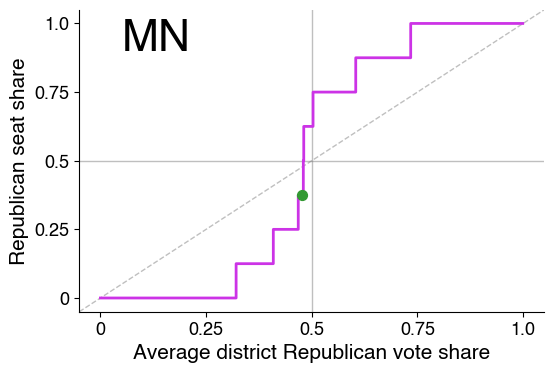

In [18]:
# Plot a UPS curve corresponding to the election we pulled above

ups_votes, ups_seats = ups_linear(rep_vote_shares_by_district)
plot_ups(average_district_republican_vote_share, rep_seat_share, ups_votes, ups_seats, state)



In [19]:
def ups_linear_using_statewide_vote_share(republican_votes_by_district, democrat_votes_by_district):
    num_divisions = 1000
    vote_swings = np.arange(-1,1,1/num_divisions)

    votes = []
    seats = []
    
    vote_share_by_district, *_ = votes_to_shares_by_district(republican_votes_by_district, democrat_votes_by_district)
    republican_statewide_vote_share, *_ = votes_to_overall_vote_share(republican_votes_by_district, democrat_votes_by_district)
    
    for i in range(len(vote_swings)):
        
        delta_v = vote_swings[i]
        new_election = np.array(vote_share_by_district) + np.ones(np.shape(vote_share_by_district)) * delta_v
        
        new_election[new_election < 0] = 0
        new_election[new_election > 1] = 1
        
        new_seats = len(np.where(np.array(new_election) > 0.5)[0]) / len(new_election)
        
        votes.append(republican_statewide_vote_share + delta_v)
        seats.append(new_seats)

    interpolated_votes = np.arange(0,1,1/num_divisions)
    interpolated_seats = np.floor(np.interp(interpolated_votes,votes, seats)*len(vote_share_by_district))/len(vote_share_by_district)

    return interpolated_votes, interpolated_seats

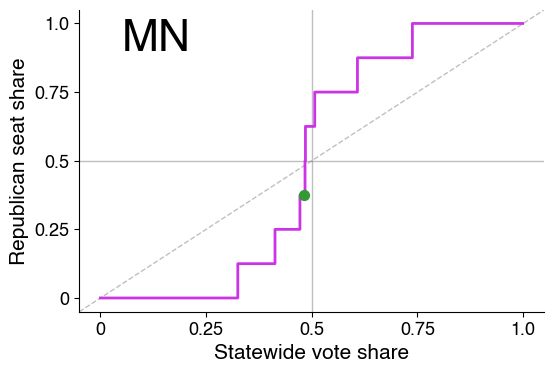

In [20]:
ups_votes, ups_seats = ups_linear_using_statewide_vote_share(rep_votes_by_district, dem_votes_by_district)
plot_ups(statewide_republican_vote_share, rep_seat_share, ups_votes, ups_seats, state,"Statewide vote share")


## Diversity of UPS curves

Now we've got a prediction for how seats change as votes change. The distinctive stair-step shape of these curves comes from the fact that seats are discrete, and jumps to new seat shares happen abruptly when the vote share in a district crosses 0.5. It can be helpful to compare different states against each other, so the cell below plots UPS plots four states in a grid. You can edit the states being plotted, but be careful to look out for warnings for states with uncontested districts.

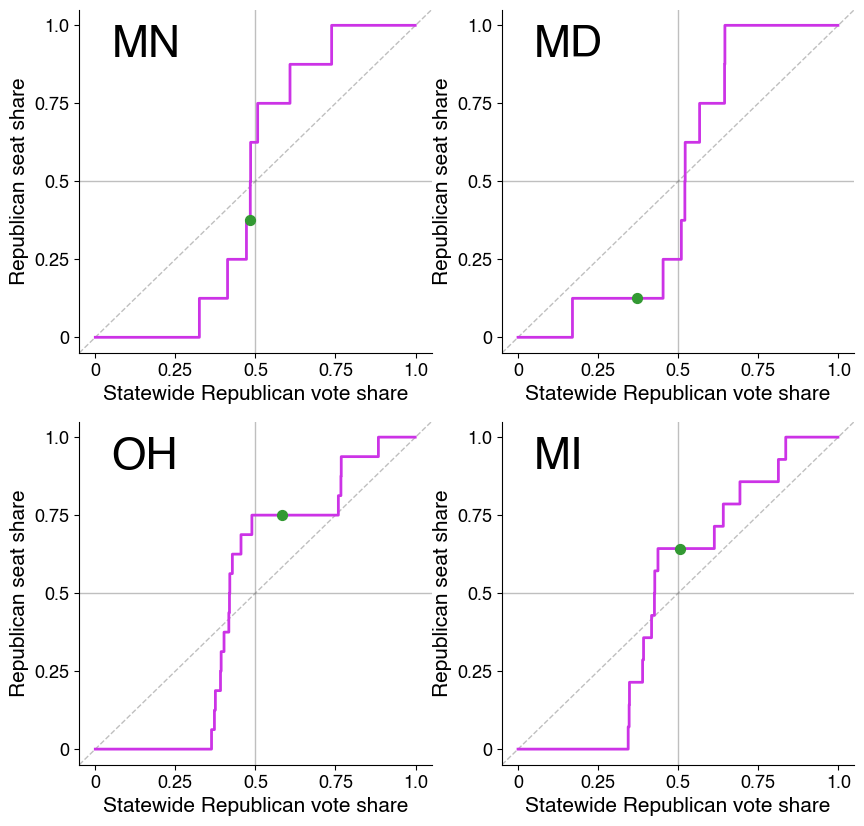

In [21]:
states = ["MN", "MD", "OH", "MI"]
year = 2016
actual_vote_share_list = []
actual_seat_share_list = []
vote_list = []
seat_list = []


for state in states:
    rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, year)
    rep_vote_shares_by_district, dem_vote_shares_by_district = votes_to_shares_by_district(rep_votes_by_district, dem_votes_by_district)
    average_district_vote_share, rep_seat_share = district_vote_shares_to_vote_and_seat_shares(rep_vote_shares_by_district)
    republican_statewide_vote_share, *_ = votes_to_overall_vote_share(rep_votes_by_district, dem_votes_by_district)   

    if want_statewide_vote_share:
        actual_vote_share_list.append(republican_statewide_vote_share)
        actual_seat_share_list.append(rep_seat_share)
        ups_votes, ups_seats = ups_linear_using_statewide_vote_share(rep_votes_by_district, dem_votes_by_district)
    else:
        actual_vote_share_list.append(average_district_vote_share)
        actual_seat_share_list.append(rep_seat_share)
        ups_votes, ups_seats = ups_linear(rep_vote_shares_by_district)

    vote_list.append(ups_votes) 
    seat_list.append(ups_seats)


plot_ups_grid(states,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list,x_label=x_label)


## Scores from the UPS curve

We've got this prediction for what could happen if the vote swung by the same amount everywhere in our state, but what kind of meaningful numbers can we derive from it? There are lots of options.

Let's start with some notation, adapted from "Theoretical Foundations and Empirical Evaluations of Partisan Fairness" (Katz et al., 2019): 

- $(v_1, v_2, ... v_n)$: vector of district vote shares for Republicans
- $V = \text{mean}_d(v_d)$: average district vote
- $S(v_1, v_2, ... v_n)$: statewide seat share, from the district vote shares

With UPS, we swing the district vote shares in a uniform way to achieve a target average vote share, $V$. We can think of the UPS curve as a function $S(V)$, where $V$ is the mean vote share achieved by the swing. 

An electoral system meets the partisan symmetry standard if $S(V) = 1 - S(1-V)$ for all $V \in [0,1]$.

The deviation from symmetry, partisan bias, is: 
$$ \beta(V) =  \frac{S(V) - (1 - S(1-V))}{2} $$

### $\beta$-average and $\beta(V^o)$

Maybe the most mathematically satisfying way to summarize $\beta(V)$ is to take the absolute value of its integral. This is half the area between the UPS curve and its 180 degree rotation around the point (0.5, 0.5), which is zero when the curve is symmetric about that rotation. 

This value being zero means that for any vote share, if you swapped the vote shares across parties, the seat shares would also swap. The code below plots this area shaded, as well as a red line showing the difference between seat shares after the actual vote shares are swapped, which is $\beta$ evaluated at the original vote share $V^o$.


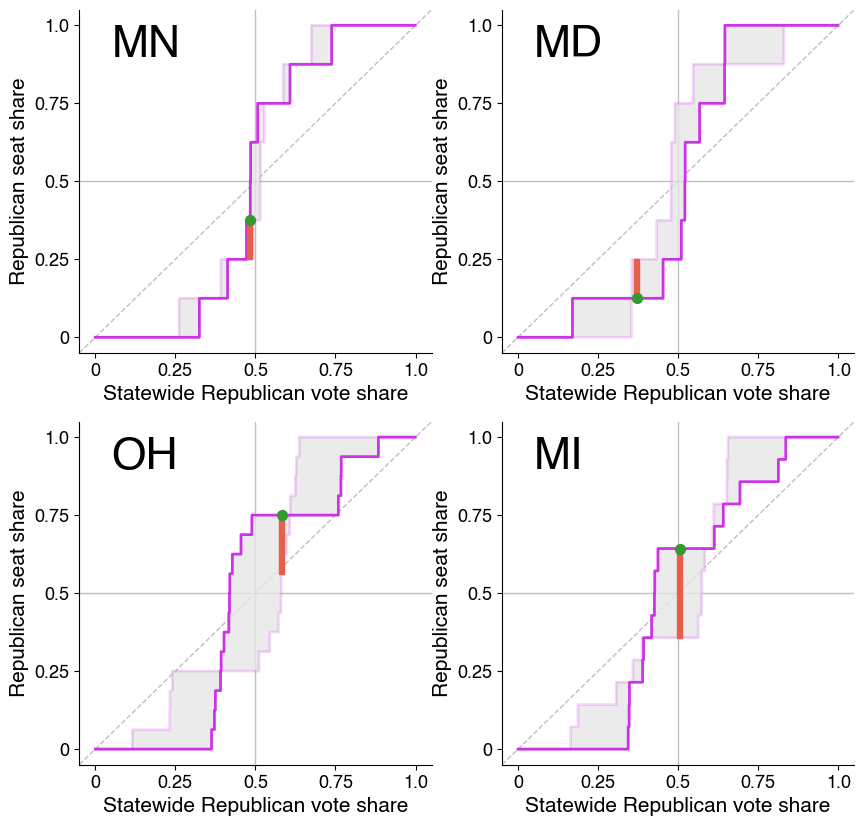

In [22]:
plot_symmetric_point_and_shading_grid(states,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list,x_label=x_label)


We could also look at the distance between the curve and the point at (0.5, 0.5), since that's the point where majority switches over in votes and seats.


### Vertical distance from (0.5, 0.5)
If we take the distance between the UPS curve and the line at $S = 0.5$, or $\beta(0.5)$, this tells us how many seats the party would win with half the vote share. If it's positive, it means they're getting more than 50% of the seats with 50% of the votes. 

###  Horizontal distance from (0.5, 0.5), or mean-median
If we take the distance between the line at $V=0.5$ and the UPS curve, it tells us either how far short a party could fall of 0.5 and still maintain a majority of seats (or how much more than 0.5 they need to obtain in order to reach a majority of seats, if the line crosses after the halfway point). This score is often called the *mean-median* score. 


These two values have the same sign for geometric reasons, but can have pretty different amplitudes. 

Let's look at the same grid from above, but with $\beta(0.5)$ and mean-median highlighted.

       Election   beta-average       beta(Vo)      beta(0.5)    Mean-median
             MN           0.03           0.12           0.12           0.02
             MD            0.1          -0.12          -0.25          -0.02
             OH           0.16           0.19           0.25           0.08
             MI            0.1           0.29           0.14           0.07


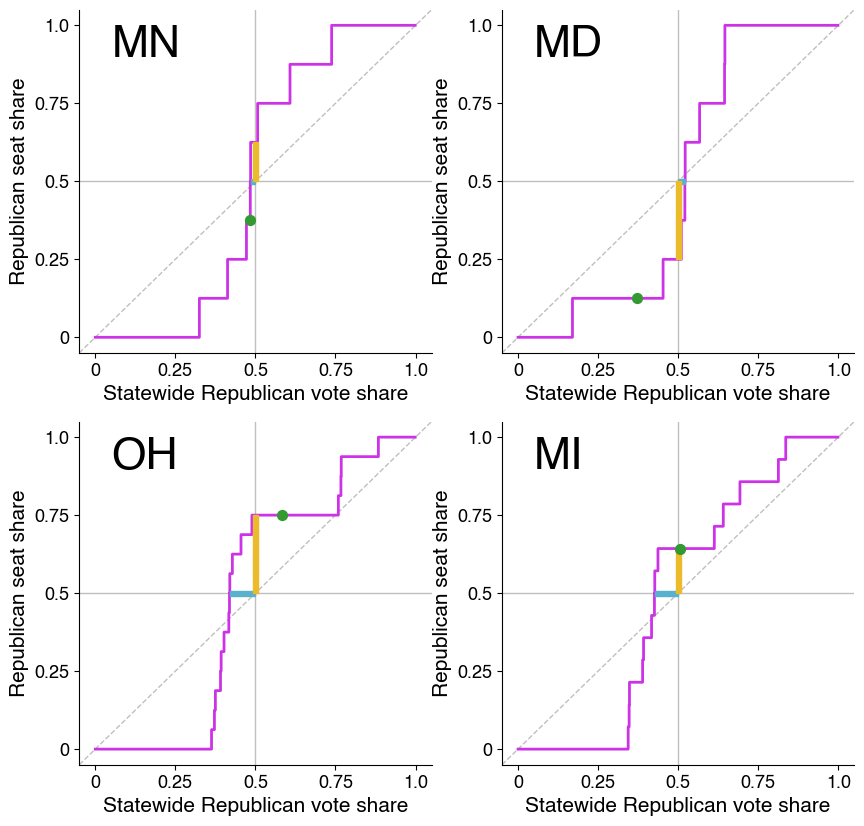

In [23]:
plot_mean_median_and_partisan_bias_grid(states,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list,x_label=x_label)
make_partisan_symmetry_table(states,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list)

## Stability of UPS curves

The UPS curves are a prediction for how seats will change as votes change. In theory, if the prediction were perfect, then vote shares from year to year might change, but would do by moving so along a fixed UPS curve. 

For some states, the UPS curves and associated partisan symmetry scores change very little from year to year, but in others the scores can be markedly different.

       Election   beta-average       beta(Vo)      beta(0.5)    Mean-median
           2012           0.01            0.0            0.0            0.0
           2014           0.05          -0.12            0.0            0.0
           2016           0.03           0.12           0.12           0.02
           2018           0.06           0.12           0.12           0.03


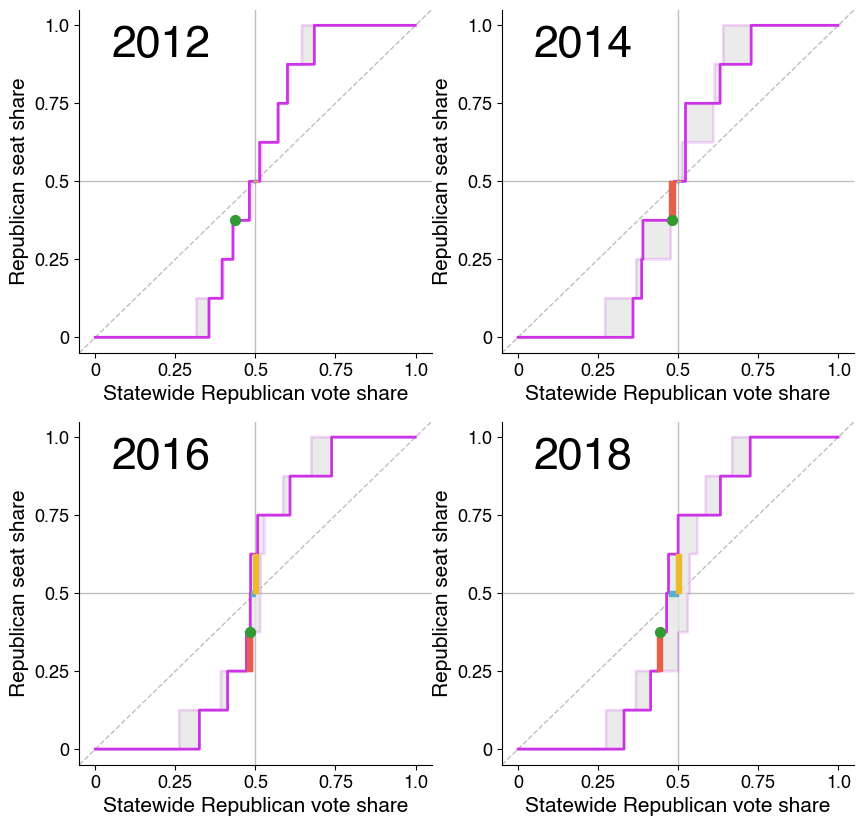

In [24]:
# Plot grid of same state, different years. 
# Before concluding anything from these plots, be sure to check that maps didn't change in that state in between elections

state = "MN"
years = ["2012", "2014", "2016", "2018"]
actual_vote_share_list = []
actual_seat_share_list = []
vote_list = []
seat_list = []

for year in years:
    rep_votes_by_district, dem_votes_by_district = get_two_party_votes(state, int(year))
    rep_vote_shares_by_district, dem_vote_shares_by_district = votes_to_shares_by_district(rep_votes_by_district, dem_votes_by_district)
    average_district_vote_share, rep_seat_share = district_vote_shares_to_vote_and_seat_shares(rep_vote_shares_by_district)
    republican_statewide_vote_share, *_ = votes_to_overall_vote_share(rep_votes_by_district, dem_votes_by_district)   

    if want_statewide_vote_share:
        actual_vote_share_list.append(republican_statewide_vote_share)
        actual_seat_share_list.append(rep_seat_share)
        ups_votes, ups_seats = ups_linear_using_statewide_vote_share(rep_votes_by_district, dem_votes_by_district)
    else:
        actual_vote_share_list.append(average_district_vote_share)
        actual_seat_share_list.append(rep_seat_share)
        ups_votes, ups_seats = ups_linear(rep_vote_shares_by_district)

    vote_list.append(ups_votes) 
    seat_list.append(ups_seats)

plot_all_measures_grid(years,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list,x_label=x_label)
make_partisan_symmetry_table(years,actual_vote_share_list, actual_seat_share_list, vote_list, seat_list)